# Project 3: Web APIs & Classification

### Contents

- [Configurations and Libraries](#Configurations-and-Libraries)
- [Functions](#Functions)


- [Scape or Import Data](#Scape-or-Import-Data)
- [Inspect and Clean Data](#Inspect-and-Clean-Data)
- [Output Clean Data](#Output-Clean-Data)


- [EDA](#EDA)


- [Create Feature Matrix and Target](#Create-Feature-Matrix-and-Target)
- [Logistic Regression Model](#Logistic-Regression-Model)
- [Bayes Classifer](#Bayes-Classifer)
- [Models by Pipeline](#Models-by-Pipeline)
- [Models by GridSearch](#Models-by-GridSearch)


- [Sentiment Analysis](#Sentiment-Analysis)
- [Descriptive and Inferential Statistics](#Descriptive-and-Inferential-Statistics)


- [Conclusion and Recommendations](#Conclusion-and-Recommendations)

### Configurations and Libraries

In [1]:
# user configuration

# True: scape data from website -> save as json files
# False: load json files
scape_data = False

# scape data for subreddits[0] if scape_data=True
scape_index = 0
# scape data for subreddits[1] if scape_data=True
#scape_index = 1

# Number of Reddit API requests
# Note: 25 posts are scaped per request.
num_requests = 50

# Number of Posts used (per Subreddit) to build models
posts_limit = 900

# Subreddits List
subreddits = ['boardgames','mobilegames']

# Base URL for scaping
url = "https://www.reddit.com/r/"

# User Agent Settings
headers = {'User-agent':'Bleep blorp bot 0.1'}

In [2]:
# import libraries

# maths
import scipy.stats as stats
import numpy as np
import pandas as pd
#from pandas.api.types import is_numeric_dtype

# visual
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
%matplotlib inline

# modelling
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn import linear_model
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score,mean_squared_error,confusion_matrix,accuracy_score
from sklearn.pipeline import make_pipeline,Pipeline

# nlp
from sklearn.feature_extraction.text import CountVectorizer,HashingVectorizer,TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from nltk.stem import PorterStemmer,WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import spacy
from spacy.tokens import Doc
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# web
import requests
import json

# others
import time
import datetime as dt
import re
import os

In [3]:
# file paths

input_path = '../data/input/'
output_path = '../data/output/'

### Functions

In [4]:
# output scaped data to json files

def write_json_files(data):    
    
    timestamp = dt.datetime.now()
    timestamp = timestamp.strftime(" %Y_%m_%d %H_%M_%S")
    
    filepath = input_path + subreddits[scape_index] + '/'
    filename = subreddits[scape_index] + timestamp + '.json'
    
    if not os.path.exists(filepath):
        os.makedirs(filepath)
    
    file = open(filepath + filename,"w+")    
    json.dump(data,file)
    
    print('created',filename)

In [5]:
# create posts list from json files

def read_json_files(subreddit):   
    
    files = []    
    filepath = input_path + subreddit

    # r=root, d=directories, f = files
    for r, d, f in os.walk(filepath):
        for file in f:
            if '.json' in file:
                files.append(os.path.join(r, file))
                
    posts = []

    # load in newer jsons first
    for f in files[::-1]:
        print(f)
        file_data = open(f).read()
        json_data = json.loads(file_data)

        posts.extend(json_data['data']['children'])
        after = json_data['data']['after']
        
    return posts

In [6]:
# created df with posts

def create_df(posts,df):

    for idx,p in enumerate(posts):

        p_keys = p['data'].keys()

        for col in cols:

            if col in p_keys:
                df.at[idx,col] = p['data'][col]
            else:
                df.at[idx,col] = np.nan
                print(idx,col,'nan')
                
    return df

In [7]:
# clean data using re library and WordNetLemmatizer

# Reference: https://towardsdatascience.com/the-real-world-as-seen-on-twitter-sentiment-analysis-part-one-5ac2d06b63fb

wnl = WordNetLemmatizer()

def clean_text(text):
    
    #print(text)    
    text = text.lower() # To lowercase    
    text = re.sub(r'\&\w*;', '', text) # Remove HTML special entities (e.g. &amp;)        
    text = re.sub(r'\s\s+', ' ', text) # Remove whitespace (including new line characters)        
    text = re.sub(r'https?:\/\/.*\/\w*', '', text) # Remove hyperlinks 
    #print(text)
    
    words = text.split()
    #print(words)
    
    words_2 = []

    for word in words: 
        word_2 = wnl.lemmatize(word)
        #if word != word_2:
            #print(word,word_2)
        words_2.append(word_2)      

    output = ' '.join(words_2)
    #print(output)
    return output 

In [8]:
# for sentiment analysis

sentiment_analyzer = SentimentIntensityAnalyzer()

def polarity_scores(doc):
    return sentiment_analyzer.polarity_scores(doc.text)

Doc.set_extension('polarity_scores', getter=polarity_scores) 
nlp = spacy.load('en')

### Scape or Import Data

In [9]:
# get json_data with multiple requests

if scape_data == True:

    posts = []
    after = None

    for i in range(1,num_requests+1):

        if after == None:
            params = {}
        else:
            params = {'after':after}

        json_url = url + subreddits[scape_index] + '.json'
        response = requests.get(json_url,params=params,headers=headers)

        if response.status_code == 200:       

            print('process request',i)

            json_data = response.json()
            posts.extend(json_data['data']['children'])
            after = json_data['data']['after']

            # save scaped data to files
            write_json_files(json_data)        

        else:
            print(response.status_code)
            break

        time.sleep(2)

In [10]:
# load json data from files (saved previously in input folder)

if scape_data == False:
    
    posts_a = read_json_files(subreddits[0])
    posts_b = read_json_files(subreddits[1])      

../data/input/boardgames\boardgames 2019_07_19 21_42_59.json
../data/input/boardgames\boardgames 2019_07_19 21_42_56.json
../data/input/boardgames\boardgames 2019_07_19 21_42_53.json
../data/input/boardgames\boardgames 2019_07_19 21_42_50.json
../data/input/boardgames\boardgames 2019_07_19 21_42_48.json
../data/input/boardgames\boardgames 2019_07_19 21_42_45.json
../data/input/boardgames\boardgames 2019_07_19 21_42_42.json
../data/input/boardgames\boardgames 2019_07_19 21_42_39.json
../data/input/boardgames\boardgames 2019_07_19 21_42_36.json
../data/input/boardgames\boardgames 2019_07_19 21_42_32.json
../data/input/boardgames\boardgames 2019_07_19 21_42_29.json
../data/input/boardgames\boardgames 2019_07_19 21_42_27.json
../data/input/boardgames\boardgames 2019_07_19 21_42_24.json
../data/input/boardgames\boardgames 2019_07_19 21_42_21.json
../data/input/boardgames\boardgames 2019_07_19 21_42_18.json
../data/input/boardgames\boardgames 2019_07_19 21_42_15.json
../data/input/boardgames

../data/input/mobilegames\mobilegames 2019_07_19 21_38_03.json
../data/input/mobilegames\mobilegames 2019_07_19 21_38_01.json
../data/input/mobilegames\mobilegames 2019_07_19 21_37_58.json
../data/input/mobilegames\mobilegames 2019_07_19 21_37_56.json
../data/input/mobilegames\mobilegames 2019_07_19 21_37_53.json
../data/input/mobilegames\mobilegames 2019_07_19 21_37_51.json
../data/input/mobilegames\mobilegames 2019_07_19 21_37_48.json
../data/input/mobilegames\mobilegames 2019_07_19 21_37_46.json
../data/input/mobilegames\mobilegames 2019_07_17 20_17_16.json
../data/input/mobilegames\mobilegames 2019_07_17 20_17_12.json
../data/input/mobilegames\mobilegames 2019_07_17 20_17_09.json
../data/input/mobilegames\mobilegames 2019_07_17 20_17_05.json
../data/input/mobilegames\mobilegames 2019_07_17 20_17_02.json
../data/input/mobilegames\mobilegames 2019_07_17 20_16_58.json
../data/input/mobilegames\mobilegames 2019_07_17 20_16_54.json
../data/input/mobilegames\mobilegames 2019_07_17 20_16_

In [11]:
# posts count info

if scape_data == False:
    
    total_posts_a = len(posts_a)
    unique_posts_a = len(set(p['data']['name'] for p in posts_a))
    total_posts_b = len(posts_b)
    unique_post_b = len(set(p['data']['name'] for p in posts_b))
    
    print('total number of posts:',total_posts_a)
    print('unique number of posts:',unique_posts_a)
    print('')
    print('total number of posts:',total_posts_b)
    print('unique number of posts:',unique_post_b)

total number of posts: 2235
unique number of posts: 1165

total number of posts: 2204
unique number of posts: 956


### Inspect and Clean Data

In [12]:
# create empty df

#cols = list(posts_a[0]['data'].keys())
cols = ['name','title','score','selftext']

df = pd.DataFrame(columns=cols)
df_a = pd.DataFrame(columns=cols)
df_b = pd.DataFrame(columns=cols)

In [13]:
# convert posts to df

df_a = create_df(posts_a,df_a)
df_b = create_df(posts_b,df_b)

In [14]:
# remove rows with duplicated name

print(len(df_a))
print(len(df_b))
print("")

df_a.drop_duplicates(subset='name',inplace=True)
df_b.drop_duplicates(subset='name',inplace=True)

print(len(df_a))
print(len(df_b))

2235
2204

1165
956


In [15]:
df_a.head()

,name,title,score,selftext
0,t3_ccwwo2,What player mats look like after lamination,12,http://imgur.com/gallery/Ab1Q9CQ\n\nSearched t...
1,t3_ccppxz,Anyone playing in downtown Toronto?,69,I've built up a small game collection lately -...
2,t3_ccqzz1,I made an app to help run my PitchCar tourname...,46,
3,t3_ccwwjl,Pandemic Legacy s1 *September spoilers*,8,Just want to make sure cause this seems weird....
4,t3_cctvi9,Rumbleslam is the best game I almost never hea...,17,https://imgur.com/a/tPFXI9B\n\nI think I gloss...


In [16]:
# list all columns

print(df_a.columns)

Index(['name', 'title', 'score', 'selftext'], dtype='object')


In [17]:
# output 1st 5 records

df_a.head()

,name,title,score,selftext
0,t3_ccwwo2,What player mats look like after lamination,12,http://imgur.com/gallery/Ab1Q9CQ\n\nSearched t...
1,t3_ccppxz,Anyone playing in downtown Toronto?,69,I've built up a small game collection lately -...
2,t3_ccqzz1,I made an app to help run my PitchCar tourname...,46,
3,t3_ccwwjl,Pandemic Legacy s1 *September spoilers*,8,Just want to make sure cause this seems weird....
4,t3_cctvi9,Rumbleslam is the best game I almost never hea...,17,https://imgur.com/a/tPFXI9B\n\nI think I gloss...


In [18]:
# df_a summary

df_a_desc = df_a.describe()
df_a_desc

,name,title,score,selftext
count,1165,1165,1165,1165
unique,1165,1165,202,987
top,t3_ca35cf,Alternate ways to play Killer Party,0,
freq,1,1,76,137


In [19]:
# Check for nulls in columns

null_cols = df_a.isnull().sum()
mask_null = null_cols > 0
null_cols[mask_null].sort_values(ascending=False)

Series([], dtype: int64)

In [20]:
# Check for nulls in rows

null_rows = df_a.isnull().sum(axis=1)
mask_null = null_rows > 0
null_rows[mask_null].sort_values(ascending=False)

Series([], dtype: int64)

In [21]:
# show column summary

df_a_info = df_a.info()
df_a_info

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1165 entries, 0 to 2178
Data columns (total 4 columns):
name        1165 non-null object
title       1165 non-null object
score       1165 non-null object
selftext    1165 non-null object
dtypes: object(4)
memory usage: 45.5+ KB


In [22]:
# limit no of rows in each df

df_a = df_a[:posts_limit]
df_b = df_b[:posts_limit]

In [23]:
# clean text for df_a and df_b

df_a['title'] = df_a['title'].apply(clean_text)
df_b['title'] = df_b['title'].apply(clean_text)

df_a['selftext'] = df_a['selftext'].apply(clean_text)
df_b['selftext'] = df_b['selftext'].apply(clean_text)

### Output Clean Data

In [24]:
# output to csv

df_a.to_csv(output_path + subreddits[0] + '.csv')
df_b.to_csv(output_path + subreddits[1] + '.csv')

### EDA

In [25]:
# print top words in df_a

cvec = CountVectorizer(stop_words='english')
cvec.fit(df_a['title'])

len_features = len(cvec.get_feature_names())
print(len_features)

df_a_cv = pd.DataFrame(cvec.transform(df_a['title']).todense(),columns=cvec.get_feature_names())

top_a = df_a_cv.sum(axis=0)
top_a.sort_values(ascending = False).head(20)

2037


game              319
board             115
2019               55
question           46
card               46
play               44
july               38
player             32
new                31
help               31
boardgames         29
rule               25
kickstarter        25
discussion         25
table              24
games              24
year               23
best               22
recommendation     22
review             22
dtype: int64

In [26]:
# print top words in df_b

cvec = CountVectorizer(stop_words='english')
cvec.fit(df_b['title'])

len_features = len(cvec.get_feature_names())
print(len_features)

df_b_cv = pd.DataFrame(cvec.transform(df_b['title']).todense(),columns=cvec.get_feature_names())

top_b = df_b_cv.sum(axis=0)
top_b.sort_values(ascending = False).head(20)

1869


game        416
mobile      205
android     101
new          73
play         63
gameplay     52
like         41
looking      38
ios          38
best         36
good         35
io           34
look         29
free         28
help         26
2018         24
review       22
games        21
pubg         20
check        20
dtype: int64

In [27]:
# get top words in df_a

df_top_a = top_a.to_frame(name='count')
df_top_a['word'] = df_top_a.index
df_top_a.reset_index(drop=True, inplace=True)
df_top_a['freq'] = df_top_a['count'] / len(df_a) * 100

cols = ['word','count','freq']
df_top_a = df_top_a[cols]
df_top_a.sort_values(by='count',ascending=False, inplace=True)
df_top_a.head(10)

,word,count,freq
776,game,319,35.444444
244,board,115,12.777778
35,2019,55,6.111111
311,card,46,5.111111
1429,question,46,5.111111
1316,play,44,4.888889
977,july,38,4.222222
1318,player,32,3.555556
853,help,31,3.444444
1194,new,31,3.444444


In [28]:
# get top words in df_b

df_top_b = top_b.to_frame(name='count')
df_top_b['word'] = df_top_b.index
df_top_b.reset_index(drop=True, inplace=True)
df_top_b['freq'] = df_top_b['count'] / len(df_b) * 100

cols = ['word','count','freq']
df_top_b = df_top_b[cols]
df_top_b.sort_values(by='count',ascending=False, inplace=True)
df_top_b.head(10)

,word,count,freq
690,game,416,46.222222
1084,mobile,205,22.777778
94,android,101,11.222222
1134,new,73,8.111111
1238,play,63,7.000000
693,gameplay,52,5.777778
970,like,41,4.555556
990,looking,38,4.222222
889,ios,38,4.222222
178,best,36,4.000000


As expected, game and board are the top 2 words in Board Games Subreddit.


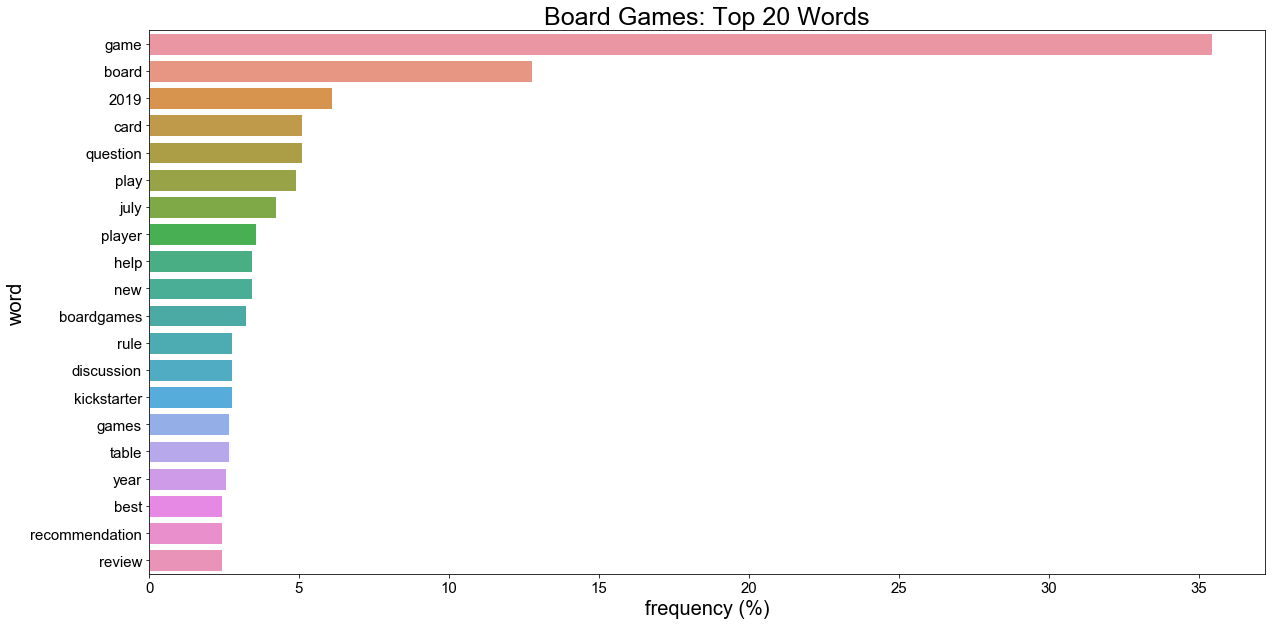

In [29]:
plt.figure(figsize=(20,10))
plt.title('Board Games: Top 20 Words',fontsize=25)

sns.set_style("whitegrid")
sns.barplot(data=df_top_a.head(20),x='freq',y='word',orient='h')

plt.xlabel('frequency (%)',fontsize=20)
plt.ylabel('word',fontsize=20)
plt.tick_params(labelsize=15)

print('As expected, game and board are the top 2 words in Board Games Subreddit.')

Interesting to note that 2018 is among the top 20 words for mobile games.
The subreddits have some common words. I will plot a Venn Diagram next to show those common words.


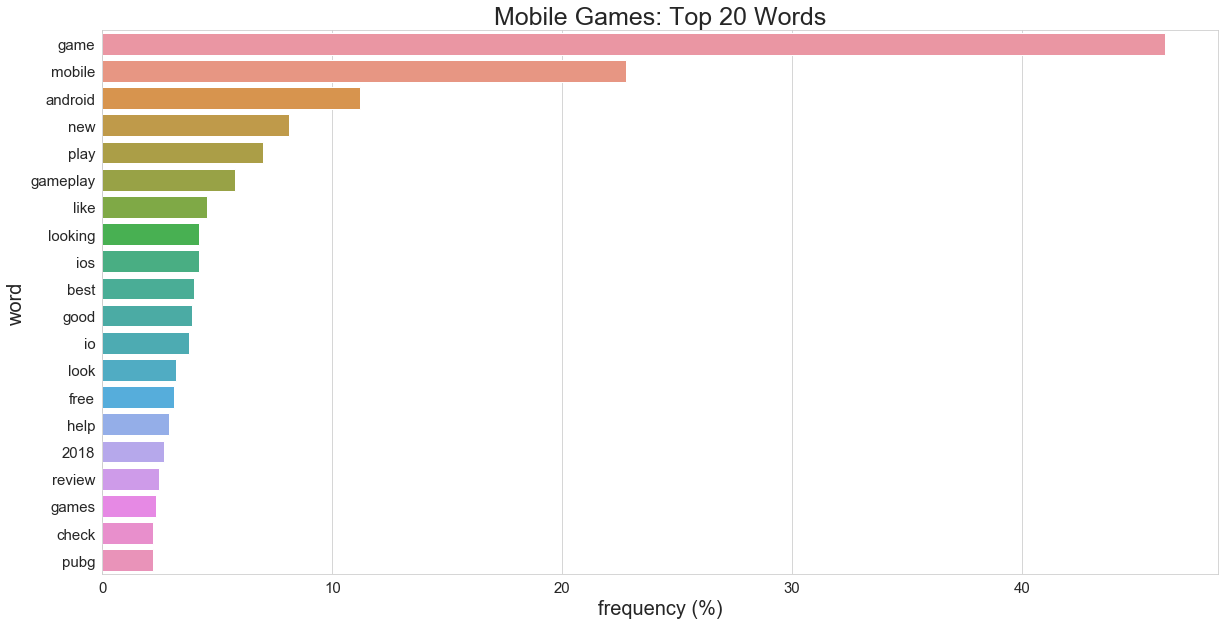

In [30]:
plt.figure(figsize=(20,10))
plt.title('Mobile Games: Top 20 Words',fontsize=25)

sns.set_style("whitegrid")
sns.barplot(data=df_top_b.head(20),x='freq',y='word',orient='h')

plt.xlabel('frequency (%)',fontsize=20)
plt.ylabel('word',fontsize=20)
plt.tick_params(labelsize=15)

print('Interesting to note that 2018 is among the top 20 words for mobile games.')
print('The subreddits have some common words. I will plot a Venn Diagram next to show those common words.')

Venn Diagram below shows the top 20 words for both subreddits.
There are 7 common words as expected for the subreddits given their similarities.


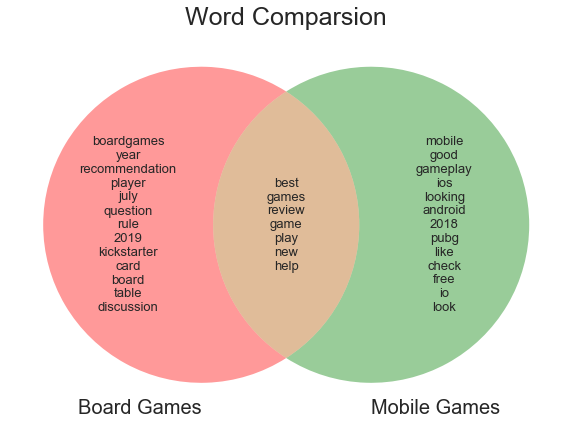

In [31]:
plt.figure(figsize=(10,10))
plt.title('Word Comparsion',fontsize=25)

set_a = set(df_top_a['word'][:20])
set_b = set(df_top_b['word'][:20])

venn = venn2([set_a,set_b],set_labels=['Board Games','Mobile Games'])

venn.get_label_by_id('100').set_text('\n'.join(map(str,set_a-set_b)))
venn.get_label_by_id('110').set_text('\n'.join(map(str,set_a&set_b)))
venn.get_label_by_id('010').set_text('\n'.join(map(str,set_b-set_a)))

venn.get_label_by_id('A').set_size(20)
venn.get_label_by_id('B').set_size(20)
venn.get_label_by_id('100').set_size(13)
venn.get_label_by_id('110').set_size(13)
venn.get_label_by_id('010').set_size(13)

print('Venn Diagram below shows the top 20 words for both subreddits.')
print('There are 7 common words as expected for the subreddits given their similarities.')

### Create Feature Matrix and Target

In [32]:
# create df by appending df_a and df_b

df = df.append(df_a)
df = df.append(df_b)

df.reset_index(drop=True,inplace=True)

In [33]:
# create target (use one hot encoding)

df['is_a'] = 0
df['is_a'].iloc[0:len(df_a)] = 1

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [34]:
# create X (feature matrix) and y (target)

X = df[['title']]
y = df['is_a'].values

X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.7,test_size=0.3,stratify=y,random_state=3050)

In [35]:
# check train and test data

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1260, 1)
(540, 1)
(1260,)
(540,)


In [36]:
print('baseline score:',y_test.mean())

baseline score: 0.5


### Logistic Regression Model

In [37]:
# create baseline model with CountVectorizer

cvec_0 = CountVectorizer()
cvec_0.fit(X_train['title'])

len_features = len(cvec_0.get_feature_names())
print(len_features)

X_train_cv_0 = pd.DataFrame(cvec_0.transform(X_train['title']).todense(),columns=cvec_0.get_feature_names())
X_test_cv_0 = pd.DataFrame(cvec_0.transform(X_test['title']).todense(),columns=cvec_0.get_feature_names())

# use with Logistic Regression

lr_model_0 = LogisticRegression()
lr_model_0.fit(X_train_cv_0,y_train)

score = lr_model_0.score(X_test_cv_0, y_test)
print('score:',score)

2858


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


score: 0.8703703703703703


In [38]:
# create another model with CountVectorizer

cvec_1 = CountVectorizer(stop_words='english')
cvec_1.fit(X_train['title'])

len_features = len(cvec_1.get_feature_names())
print(len_features)

X_train_cv_1 = pd.DataFrame(cvec_1.transform(X_train['title']).todense(),columns=cvec_1.get_feature_names())
X_test_cv_1 = pd.DataFrame(cvec_1.transform(X_test['title']).todense(),columns=cvec_1.get_feature_names())

# use with LogisticRegression

lr_model_1 = LogisticRegression()
lr_model_1.fit(X_train_cv_1,y_train)

score = lr_model_1.score(X_test_cv_1, y_test)
print('score:',score)

print('baseline model (lr_model_0) has better accuracy than 2nd model (lr_model_1)')

2663


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


score: 0.8629629629629629
baseline model (lr_model_0) has better accuracy than 2nd model (lr_model_1)


### Bayes Classifer

In [39]:
# create baseline model with MultinomialNB model
# use X_train_cv_0, X_test_cv_0, y_train, y_test

mnb = MultinomialNB()

mnb.fit(X_train_cv_0,y_train)
y_pred = mnb.predict(X_test_cv_0)

# score MultinomialNB model

train_score = mnb.score(X_train_cv_0,y_train)
print('train_score:',train_score)

test_score = mnb.score(X_test_cv_0,y_test)
print('test_score:',test_score)
print('')

# create confusion matrix

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print("True Positives: %s" % tp)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Negatives: %s" % tn)
print('')

# confusion matrix metrics

accuracy = (tp+tn)/(tp+fp+fn+tn)
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
precision = tp/(tp+fp)

print('Accuracy:',round(accuracy,3))
print('Sensitivity:',round(sensitivity,3))
print('Specificity:',round(specificity,3))
print('Precision:',round(precision,3))
print('')

print('This model (baseline Bayes Classifer) makes better prediction (with higher test scores) than the logistic regression models (built in earlier cells)')

train_score: 0.976984126984127
test_score: 0.8944444444444445

True Positives: 242
False Positives: 29
False Negatives: 28
True Negatives: 241

Accuracy: 0.894
Sensitivity: 0.896
Specificity: 0.893
Precision: 0.893

This model (baseline Bayes Classifer) makes better prediction (with higher test scores) than the logistic regression models (built in earlier cells)


In [40]:
# create another model with MultinomialNB model
# use X_train_cv_1, X_test_cv_1, y_train, y_test

mnb = MultinomialNB()

mnb.fit(X_train_cv_1,y_train)
y_pred = mnb.predict(X_test_cv_1)

# score MultinomialNB model

train_score = mnb.score(X_train_cv_1,y_train)
print('train_score:',train_score)

test_score = mnb.score(X_test_cv_1,y_test)
print('test_score:',test_score)
print('')

# create confusion matrix

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print("True Positives: %s" % tp)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Negatives: %s" % tn)
print('')

# confusion matrix metrics

accuracy = (tp+tn)/(tp+fp+fn+tn)
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
precision = tp/(tp+fp)

print('Accuracy:',round(accuracy,3))
print('Sensitivity:',round(sensitivity,3))
print('Specificity:',round(specificity,3))
print('Precision:',round(precision,3))
print('')

print('This Bayes Classifer model (countvectorizer with stopwords) performs slightly worse than baseline model (countvectorizer without stopwords)')

train_score: 0.9698412698412698
test_score: 0.8759259259259259

True Positives: 229
False Positives: 26
False Negatives: 41
True Negatives: 244

Accuracy: 0.876
Sensitivity: 0.848
Specificity: 0.904
Precision: 0.898

This Bayes Classifer model (countvectorizer with stopwords) performs slightly worse than baseline model (countvectorizer without stopwords)


### Models by Pipeline

In [41]:
# TfidfVectorizer with LogisticRegression

model = make_pipeline(TfidfVectorizer(stop_words='english',
                                      sublinear_tf=True,
                                      max_df=0.5,
                                      max_features=1000,
                                     ngram_range=(1,2)),
                      LogisticRegression(),
                      )

model.fit(X_train['title'], y_train)
y_pred = model.predict(X_test['title'])

print('accuracy_score',accuracy_score(y_test, y_pred))
print("Number of features:", len(model.steps[0][1].get_feature_names()))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


accuracy_score 0.8481481481481481
Number of features: 1000


In [42]:
# TfidfVectorizer with MultinomialNB

model = make_pipeline(TfidfVectorizer(stop_words='english',
                                      sublinear_tf=True,
                                      max_df=0.5,
                                      max_features=1000,
                                      ngram_range=(1,2)),
                      MultinomialNB()
                      )

model.fit(X_train['title'], y_train)
y_pred = model.predict(X_test['title'])

print('accuracy_score',accuracy_score(y_test, y_pred))
print("Number of features:", len(model.steps[0][1].get_feature_names()))
print('')

print('This model (TfidfVectorizer and MultinomialNB) makes slightly better prediction than earlier model (TfidfVectorizer and LogisticRegression).')

accuracy_score 0.8666666666666667
Number of features: 1000

This model (TfidfVectorizer and MultinomialNB) makes slightly better prediction than earlier model (TfidfVectorizer and LogisticRegression).


### Models by GridSearch

In [43]:
# create gs_model using gridsearch

tfidf = TfidfVectorizer()
lr = LogisticRegression()

pipe = Pipeline([('tfidf', tfidf), ('lr', lr)])

params = {
        'tfidf__stop_words': ['english',None],
        'tfidf__max_features': range(1000,11000,1000),
        #'tfidf__max_df': np.arange(0.1,0.6,0.1),
        'tfidf__ngram_range': [(1, 1), (1, 2),(1,3)]
        }

gs_model = GridSearchCV(
    pipe,
    params,
    cv=5,
    verbose=1,
    n_jobs=3,
    return_train_score=False
)

gs_model.fit(X_train['title'], y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  46 tasks      | elapsed:   18.6s
[Parallel(n_jobs=3)]: Done 300 out of 300 | elapsed:   27.0s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=3,
       param_grid={'tfidf__stop_words': ['english', None], 'tfidf__max_features': range(1000, 11000, 1000), 'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring=None, verbose=1)

In [44]:
y_pred = gs_model.predict(X_test['title'])

score = gs_model.score(X_test['title'], y_test)
print('score:',score)

print('best_score:', gs_model.best_score_)
print('best_params:', gs_model.best_params_)

score: 0.8796296296296297
best_score: 0.8365079365079365
best_params: {'tfidf__max_features': 9000, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': None}


In [45]:
# create gs_model_2 using gridsearch

tfidf = TfidfVectorizer()
mnb = MultinomialNB()

pipe = Pipeline([('tfidf', tfidf), ('mnb', mnb)])

params = {
        'tfidf__stop_words': ['english',None],
        'tfidf__max_features': range(1000,11000,1000),
        #'tfidf__max_df': np.arange(0.1,0.6,0.1),
        'tfidf__ngram_range': [(1, 1), (1, 2),(1,3)]
        }

gs_model_2 = GridSearchCV(
    pipe,
    params,
    cv=5,
    verbose=1,
    n_jobs=3,
    return_train_score=False
)

gs_model_2.fit(X_train['title'], y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done 158 tasks      | elapsed:    4.4s
[Parallel(n_jobs=3)]: Done 300 out of 300 | elapsed:    8.3s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,...rue,
        vocabulary=None)), ('mnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid='warn', n_jobs=3,
       param_grid={'tfidf__stop_words': ['english', None], 'tfidf__max_features': range(1000, 11000, 1000), 'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring=None, verbose=1)

In [46]:
y_pred = gs_model_2.predict(X_test['title'])

score = gs_model_2.score(X_test['title'], y_test)
print('score:',score)

print('best_score:', gs_model_2.best_score_)
print('best_params:', gs_model_2.best_params_)
print('')

print('gs_model_2 perform better perdictions (higher best_score) than gs_model.')
print('both models (for best scores) uses ngram_range of 1-2 and ignore stop words.')

score: 0.8796296296296297
best_score: 0.8626984126984127
best_params: {'tfidf__max_features': 6000, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': None}

gs_model_2 perform better perdictions (higher best_score) than gs_model.
both models (for best scores) uses ngram_range of 1-2 and ignore stop words.


### Sentiment Analysis

In [47]:
# using SentimentIntensityAnalyser to find any correlations between reddit score and compound

# reddit score:
# the difference between upvotes and downvotes

# compound: 
# a metric that calculates the sum of all the lexicon ratings
# normalized between -1 (most extreme negative) and +1 (most extreme positive).

In [48]:
# drop rows with no content

df_a_sen = df_a.copy()
df_b_sen = df_b.copy()

print(len(df_a_sen))
print(len(df_b_sen))
print('')

df_a_sen['selftext'].replace('',np.nan,inplace=True)
df_b_sen['selftext'].replace('',np.nan,inplace=True)

df_a_sen.dropna(subset=['selftext'],inplace=True)
df_b_sen.dropna(subset=['selftext'],inplace=True)

print(len(df_a_sen))
print(len(df_b_sen))

900
900

797
332


In [49]:
# store sentiment scores in df_a_sen

cols = ['neg','neu','pos','compound']
for col in cols:
    df_a_sen[col] = 0.0

for idx,row in df_a_sen.iterrows():
    
    doc = nlp(row['selftext'])
    polar_score = doc._.polarity_scores

    df_a_sen.at[idx,'neg'] = polar_score['neg']
    df_a_sen.at[idx,'neu'] = polar_score['neu']
    df_a_sen.at[idx,'pos'] = polar_score['pos']
    df_a_sen.at[idx,'compound'] = polar_score['compound']

In [50]:
# store sentiment scores in df_b_sen

cols = ['neg','neu','pos','compound']
for col in cols:
    df_b_sen[col] = 0.0

for idx,row in df_b_sen.iterrows():
    
    doc = nlp(row['selftext'])
    polar_score = doc._.polarity_scores

    df_b_sen.at[idx,'neg'] = polar_score['neg']
    df_b_sen.at[idx,'neu'] = polar_score['neu']
    df_b_sen.at[idx,'pos'] = polar_score['pos']
    df_b_sen.at[idx,'compound'] = polar_score['compound']

In [51]:
df_a_sen.head()

,name,title,score,selftext,neg,neu,pos,compound
0,t3_ccwwo2,what player mat look like after lamination,12,searched this sub and google for image of the ...,0.034,0.816,0.150,0.9052
1,t3_ccppxz,anyone playing in downtown toronto?,69,i've built up a small game collection lately -...,0.044,0.905,0.051,0.0747
3,t3_ccwwjl,pandemic legacy s1 *september spoilers*,8,just want to make sure cause this seems weird....,0.124,0.798,0.078,-0.3151
4,t3_cctvi9,rumbleslam is the best game i almost never hea...,17,80's and 90's wrestling reference really shine...,0.000,0.768,0.232,0.9244
5,t3_ccvrtl,about to play eldritch horror for the first ti...,11,i'm buying eldritch horror tonight and i'm hop...,0.103,0.586,0.310,0.9183


In [52]:
df_b_sen.head()

,name,title,score,selftext,neg,neu,pos,compound
0,t3_bbdq7o,"age of z, recruiting",1,i'm looking for player who play the game age o...,0.000,0.765,0.235,0.5574
1,t3_bbb1np,there wa a java game...,1,"i remember playing an old game on my nokia, ab...",0.000,0.848,0.152,0.6124
2,t3_bb4yj9,mmorpg?,1,hi guys! can you suggest some mobile mmorpg? s...,0.000,0.544,0.456,0.9412
4,t3_baqg2e,searching for game to be transplanted from ste...,1,"hi, i am a steam game player with more than 30...",0.000,0.774,0.226,0.9498
6,t3_bamstx,ww2-style boom beach?,2,anyone remember a game on the play store that ...,0.054,0.731,0.215,0.9023


There are more posts with positive than negative sentiments.
The highest reddit score for postive and negative sentiments are 1,700 and 550 respectively (approximated).


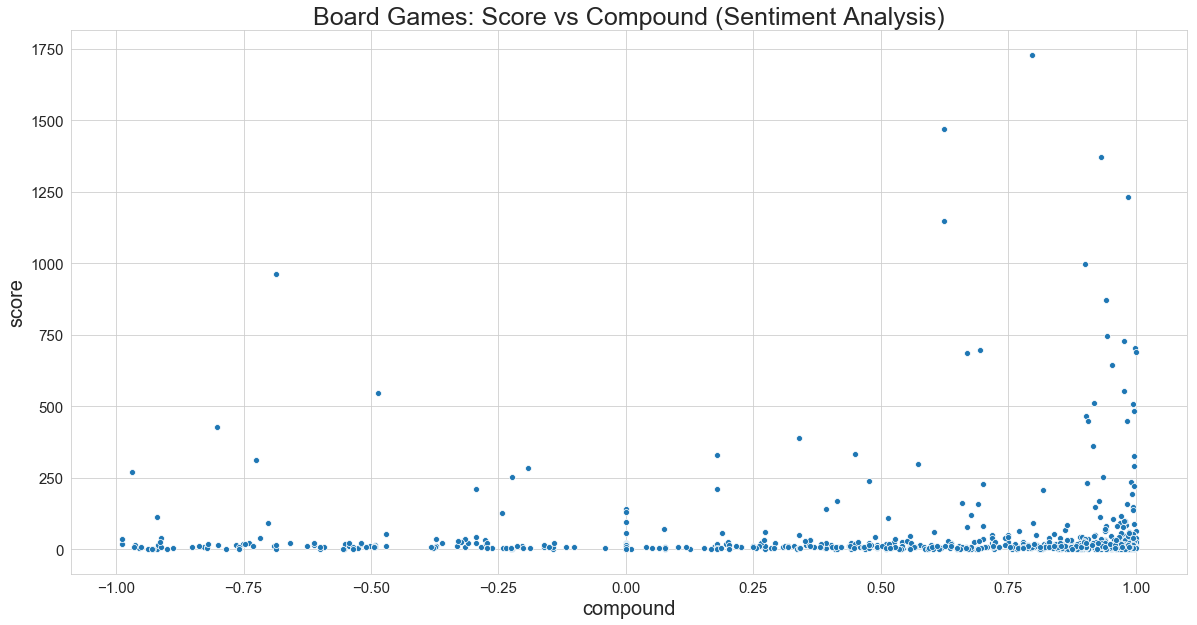

In [53]:
plt.figure(figsize=(20,10))
plt.title('Board Games: Score vs Compound (Sentiment Analysis)',fontsize=25)

sns.set_style("whitegrid")
sns.scatterplot(data=df_a_sen,x='compound',y='score')

plt.xlabel('compound',fontsize=20)
plt.ylabel('score',fontsize=20)
plt.tick_params(labelsize=15)

print('There are more posts with positive than negative sentiments.')
print('The highest reddit score for postive and negative sentiments are 1,700 and 550 respectively (approximated).')

No obvious trends between reddit scores and postive/negative sentiments.
The Mobile Game Subreddit has much lower average reddit scores compared to Board Game Subreddit.
Likely due to much lower membership for Mobile Game Subreddit.
Board Game Subbreddit has 75 times more members than Mobile Game Subreddit.


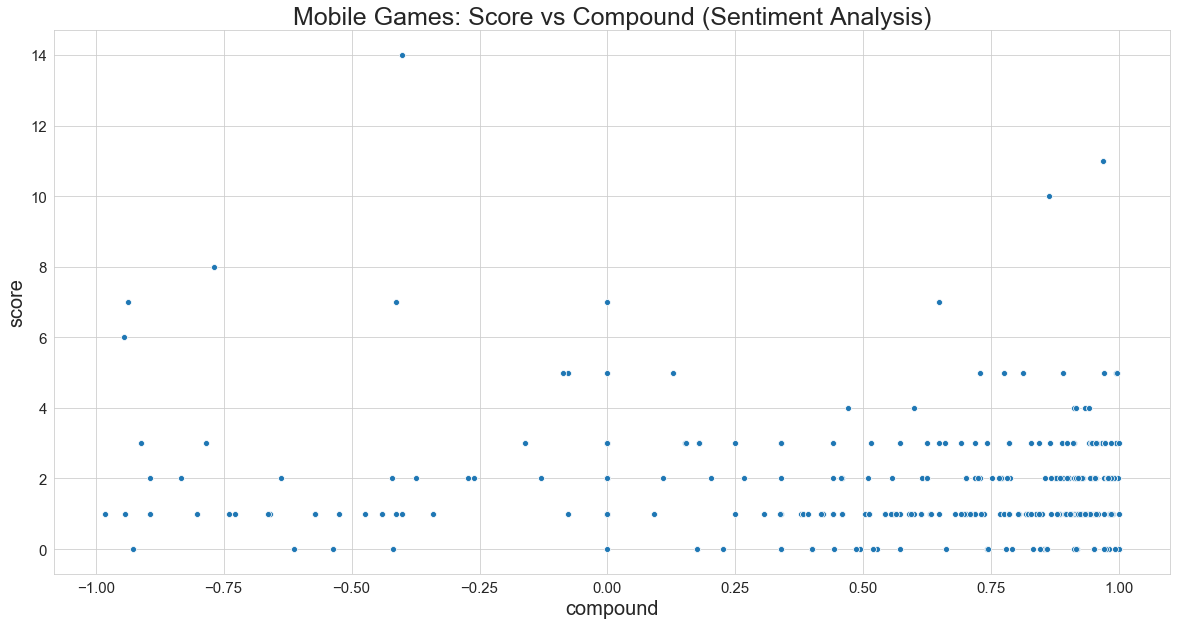

In [54]:
plt.figure(figsize=(20,10))
plt.title('Mobile Games: Score vs Compound (Sentiment Analysis)',fontsize=25)

sns.set_style("whitegrid")
sns.scatterplot(data=df_b_sen,x='compound',y='score')

plt.xlabel('compound',fontsize=20)
plt.ylabel('score',fontsize=20)
plt.tick_params(labelsize=15)

print('No obvious trends between reddit scores and postive/negative sentiments.')
print('The Mobile Game Subreddit has much lower average reddit scores compared to Board Game Subreddit.')
print('Likely due to much lower membership for Mobile Game Subreddit.')
print('Board Game Subbreddit has 75 times more members than Mobile Game Subreddit.')

In [55]:
# create bins to plot histogram later

bins = np.arange(-1,1.1,0.25)
df_a_sen['binned'] = pd.cut(df_a_sen['compound'], bins=bins)

df_a_sen['score'] = df_a_sen['score'].astype(int)
a_sen_bin = df_a_sen.groupby(df_a_sen['binned'])['score'].mean()
df_a_sen_bin = pd.DataFrame(a_sen_bin)

In [56]:
# create bins to plot histogram later

df_b_sen['binned'] = pd.cut(df_b_sen['compound'], bins=bins)

df_b_sen['score'] = df_b_sen['score'].astype(int)
b_sen_bin = df_b_sen.groupby(df_b_sen['binned'])['score'].mean()
df_b_sen_bin = pd.DataFrame(b_sen_bin)

no obvious trend observed for both postive (compount 0 to 1) and negative sentiments (compound -1.0 to 0)


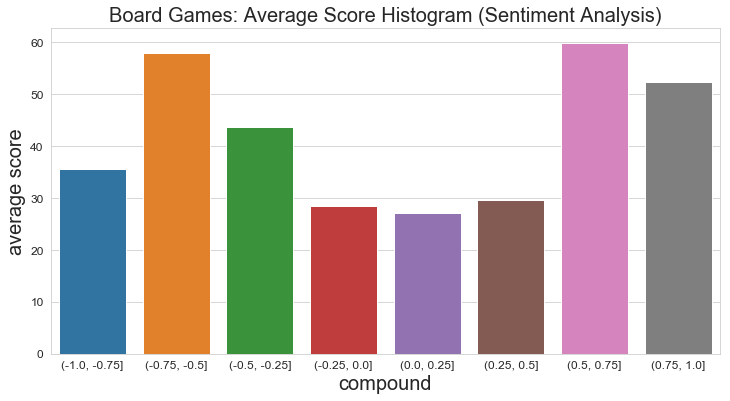

In [57]:
plt.figure(figsize=(12,6))
plt.title('Board Games: Average Score Histogram (Sentiment Analysis)',fontsize=20)

sns.set_style("whitegrid")
sns.barplot(data=df_a_sen_bin,x=df_a_sen_bin.index,y=df_a_sen_bin['score'].values)

plt.xlabel('compound',fontsize=20)
plt.ylabel('average score',fontsize=20)
plt.tick_params(labelsize=12)

print('no obvious trend observed for both postive (compount 0 to 1) and negative sentiments (compound -1.0 to 0)')

Highest average score is 3.0 for negative sentiment. Observed for compound -0.5 to -0.25.
Highest average score is 2.0 for positive sentiment. Observed for compound 0.0 to 0.25.
The difference in average score (between negative and positive sentiment) is small i.e. difference of only 1.0.


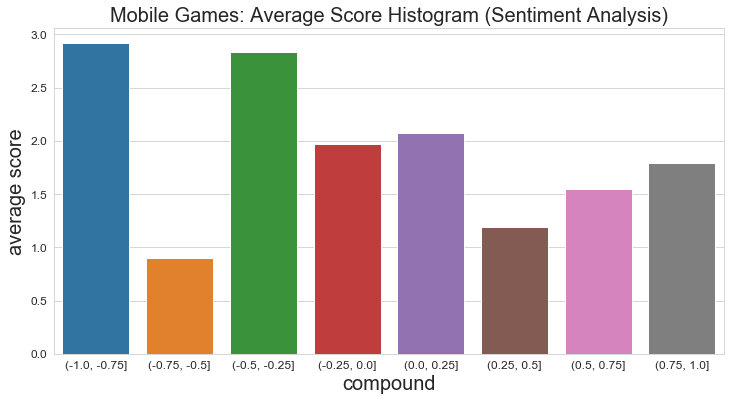

In [58]:
plt.figure(figsize=(12,6))
plt.title('Mobile Games: Average Score Histogram (Sentiment Analysis)',fontsize=20)

sns.set_style("whitegrid")
sns.barplot(data=df_b_sen_bin,x=df_b_sen_bin.index,y=df_b_sen_bin['score'].values)

plt.xlabel('compound',fontsize=20)
plt.ylabel('average score',fontsize=20)
plt.tick_params(labelsize=12)

print('Highest average score is 3.0 for negative sentiment. Observed for compound -0.5 to -0.25.')
print('Highest average score is 2.0 for positive sentiment. Observed for compound 0.0 to 0.25.')
print('The difference in average score (between negative and positive sentiment) is small i.e. difference of only 1.0.')

### Descriptive and Inferential Statistics

In [59]:
df_top_a_cv = df_a_cv[list(set_a)]
df_top_b_cv = df_b_cv[list(set_b)]

# for each post, count number of occurances (from top words list)
a_cv_has_top = df_top_a_cv.sum(axis=1)
b_cv_has_top = df_top_b_cv.sum(axis=1)

In [60]:
# create df_a_cv_has_top

df_a_cv_has_top= a_cv_has_top.value_counts().to_frame()

df_a_cv_has_top['occurances'] = df_a_cv_has_top.index

df_a_cv_has_top.reset_index(drop=True, inplace=True)

df_a_cv_has_top.rename(columns={0: "num_posts"},inplace=True)
df_a_cv_has_top['freq'] = df_a_cv_has_top["num_posts"] / len(df_a) * 100
cols = ['occurances','num_posts','freq']
df_a_cv_has_top = df_a_cv_has_top[cols]
df_a_cv_has_top.sort_values(by='occurances',inplace=True)

In [61]:
# create df_b_cv_has_top

df_b_cv_has_top= b_cv_has_top.value_counts().to_frame()

df_b_cv_has_top['occurances'] = df_b_cv_has_top.index

df_b_cv_has_top.reset_index(drop=True, inplace=True)

df_b_cv_has_top.rename(columns={0: "num_posts"},inplace=True)
df_b_cv_has_top['freq'] = df_b_cv_has_top["num_posts"] / len(df_b) * 100
cols = ['occurances','num_posts','freq']
df_b_cv_has_top = df_b_cv_has_top[cols]
df_b_cv_has_top.sort_values(by='occurances',inplace=True)

The barplot shows 42% of all post titles does not contain any of the top 20 words.
Interesting to note there is 7 occurances of top words in 2% of all post titles.


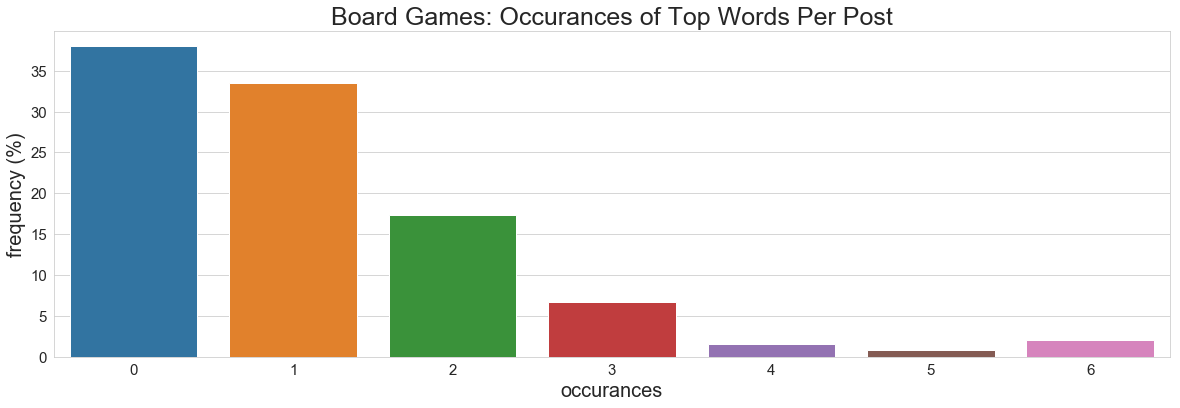

In [62]:
plt.figure(figsize=(20,6))
plt.title('Board Games: Occurances of Top Words Per Post',fontsize=25)

sns.set_style("whitegrid")

sns.barplot(data=df_a_cv_has_top,x='occurances',y='freq')

plt.xlabel('occurances',fontsize=20)
plt.ylabel('frequency (%)',fontsize=20)
plt.tick_params(labelsize=15)

print('The barplot shows 42% of all post titles does not contain any of the top 20 words.')
print('Interesting to note there is 7 occurances of top words in 2% of all post titles.')

73% of all post titles contain at least 1 occurance of top 20 words.
Frequency and occurances (of top words per post) has negative correlations.
A max of 8 occurances of top words per post title is observed.


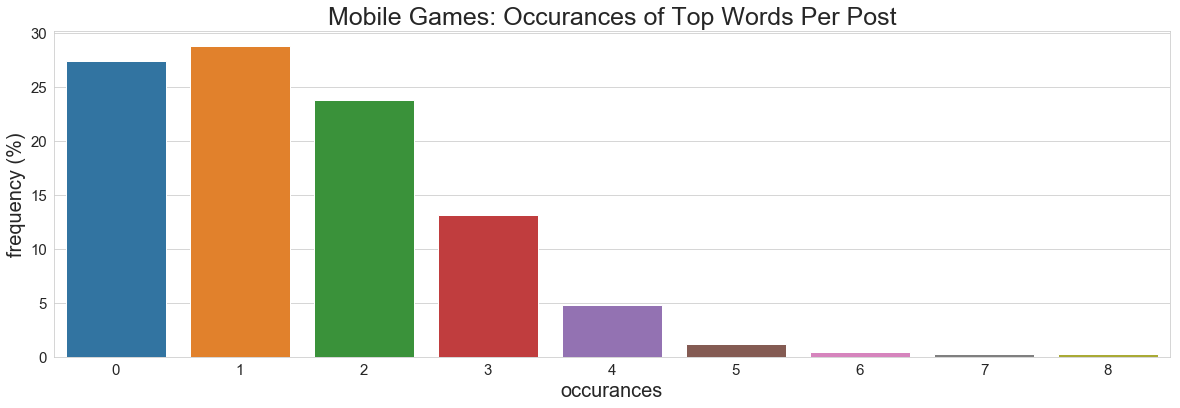

In [63]:
plt.figure(figsize=(20,6))
plt.title('Mobile Games: Occurances of Top Words Per Post',fontsize=25)

sns.set_style("whitegrid")

sns.barplot(data=df_b_cv_has_top,x='occurances',y='freq')

plt.xlabel('occurances',fontsize=20)
plt.ylabel('frequency (%)',fontsize=20)
plt.tick_params(labelsize=15)

print('73% of all post titles contain at least 1 occurance of top 20 words.')
print('Frequency and occurances (of top words per post) has negative correlations.')
print('A max of 8 occurances of top words per post title is observed.')

In [64]:
mask_a_top = a_cv_has_top == a_cv_has_top.max()
a_title = df_a[mask_a_top]['title']

print('Print the titles with 8 occurances of top 20 words for Board Games.')
print('The 8 occurances were due to a daily posts in the Subreddit.')
print('----------------------------------------------------------------------------')

for title in a_title:
    print(title)

Print the titles with 8 occurances of top 20 words for Board Games.
The 8 occurances were due to a daily posts in the Subreddit.
----------------------------------------------------------------------------
/r/boardgames daily discussion and game recommendation (july 14, 2019)
/r/boardgames daily discussion and game recommendation (july 15, 2019)
/r/boardgames daily discussion and game recommendation (july 16, 2019)
/r/boardgames daily discussion and game recommendation (july 17, 2019)
/r/boardgames daily discussion and game recommendation (july 18, 2019)
/r/boardgames daily discussion and game recommendation (july 19, 2019)
/r/boardgames daily discussion and game recommendation (july 01, 2019)
/r/boardgames daily discussion and game recommendation (july 02, 2019)
/r/boardgames daily discussion and game recommendation (july 03, 2019)
/r/boardgames daily discussion and game recommendation (july 04, 2019)
/r/boardgames daily discussion and game recommendation (july 05, 2019)
/r/boardgames

In [65]:
mask_a_top = b_cv_has_top == b_cv_has_top.max()
b_title = df_b[mask_a_top]['title']

print('Print the titles with 8 occurances of top 20 words for Mobile Games.')
print('These posts have long titles but no particular trend is observed.')
print('----------------------------------------------------------------------------')

for title in b_title:
    print('')
    print(title)

Print the titles with 8 occurances of top 20 words for Mobile Games.
These posts have long titles but no particular trend is observed.
----------------------------------------------------------------------------

[android] looking for game that are a lot like game of sultans. good or bad i'll try any of them a long a it's like that type of game. so don't be afraid to send them!

what is a good and fun mobile game that doesnt look like it made for a nine year old? sometimes i feel so stupid playing game like angry bird or temple run in the train. (still love the game though)


### Conclusion and Recommendations

[Conclusion]

- The best classification model (Naive Bayes Classifier using CountVectorizer) has a good prediction (i.e. predict using post title which subreddit a post came from) accuracy of 89%.
- Sentimental Analysis (to find any correlation between post contents and reddit scores) was inconclusive.

[Recommendations]

- To enhance classification model by adding additonal features e.g. post contents.
- To perform name entity recognition e.g. identifying existing boardgames with BoardGameGeek API (https://boardgamegeek.com/wiki/page/BGG_XML_API&redirectedfrom=XML_API)